## Gerekli Kütüphaneler

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt

Preprocessing aşamasında veri setine yapılan düzenlemeler aşağıda toplu şekilde yapılmıştır model eğitimleri için

In [71]:
df = pd.read_csv("dataset/train.csv")
df = df[df["px_height"] != 0]
df = df[df["sc_w"] != 0]
df["total_pixels"] = df["px_height"] * df["px_width"]
df["screen_area"] = df["sc_h"] * df["sc_w"]
X = df.drop("price_range", axis=1)
y = df["price_range"]

Veriseti aşağıda görüldüğü üzere 80/20 oranında train ve test olarak bölünmüştür.

Ardından gerekli modellerde kullanılmak üzere Standardization kullanıldı.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### SVM Model Eğitimi

In [61]:
# 1- SVM MODEL
# Hyperparameter Tuning (GridSearchCV ile)
# ek olarak burada da cross validation kullandım.
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print("\nEn iyi hiperparametreler (GridSearchCV):")
print(grid.best_params_)
print("En iyi CV skoru (train üzeri 3-fold ortalama):", grid.best_score_)

# En iyi bulunan SVM modelini alalım
best_svm = grid.best_estimator_

# Train ve Test Üzerinde Performans (Overfitting kontrolü)
# train_acc ve test_acc birbirine yakınsa, belirgin overfitting yoktur)
train_pred = best_svm.predict(X_train_scaled)
test_pred = best_svm.predict(X_test_scaled)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print("\nTrain accuracy:", train_acc)
print("Test accuracy:", test_acc)



En iyi hiperparametreler (GridSearchCV):
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
En iyi CV skoru (train üzeri 3-fold ortalama): 0.934020618556701

Train accuracy: 0.9683848797250859
Test accuracy: 0.9532967032967034


In [62]:
print("\nClassification Report (Test verisi):")
print(classification_report(y_test, test_pred))


Classification Report (Test verisi):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        90
           1       0.97      0.94      0.96        90
           2       0.99      0.88      0.93        91
           3       0.91      1.00      0.95        93

    accuracy                           0.95       364
   macro avg       0.96      0.95      0.95       364
weighted avg       0.96      0.95      0.95       364



In [63]:
cm = confusion_matrix(y_test, test_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[89  1  0  0]
 [ 4 85  1  0]
 [ 0  2 80  9]
 [ 0  0  0 93]]


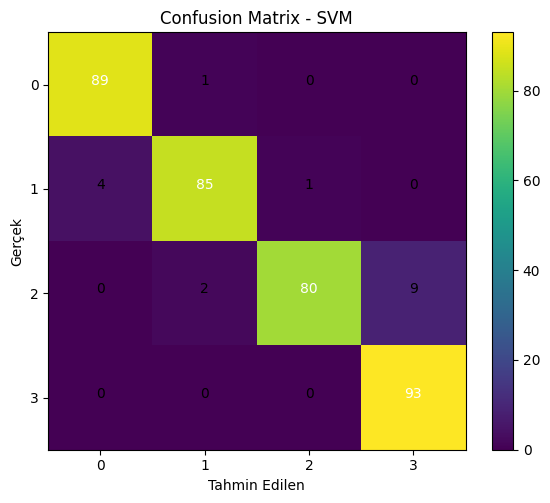

In [64]:
# Confusion Matrix Görselleştirme
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix - SVM")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

### Decision Tree Hyperparameter Tuning ile Model Eğitimi

In [65]:
# 2- DECISION TREE MODEL
from sklearn.tree import DecisionTreeClassifier

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 8]
}

dt = DecisionTreeClassifier(random_state=42)

grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

print("\n[Decision Tree] En iyi hiperparametreler (GridSearchCV):")
print(grid_dt.best_params_)
print("[Decision Tree] En iyi CV skoru (train üzeri 3-fold ortalama):", grid_dt.best_score_)

best_dt = grid_dt.best_estimator_

dt_train_pred = best_dt.predict(X_train)
dt_test_pred  = best_dt.predict(X_test)

dt_train_acc = accuracy_score(y_train, dt_train_pred)
dt_test_acc  = accuracy_score(y_test, dt_test_pred)

print("\n[Decision Tree] Train accuracy:", dt_train_acc)
print("[Decision Tree] Test accuracy:", dt_test_acc)


Fitting 5 folds for each of 72 candidates, totalling 360 fits

[Decision Tree] En iyi hiperparametreler (GridSearchCV):
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
[Decision Tree] En iyi CV skoru (train üzeri 3-fold ortalama): 0.8604810996563573

[Decision Tree] Train accuracy: 0.9642611683848797
[Decision Tree] Test accuracy: 0.8653846153846154


In [66]:
# Classification Report (Test verisi)
print("\n[Decision Tree] Classification Report (Test verisi):")
print(classification_report(y_test, dt_test_pred))


[Decision Tree] Classification Report (Test verisi):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        90
           1       0.79      0.90      0.84        90
           2       0.84      0.74      0.78        91
           3       0.89      0.90      0.90        93

    accuracy                           0.87       364
   macro avg       0.87      0.87      0.86       364
weighted avg       0.87      0.87      0.86       364



[Decision Tree] Confusion Matrix:
[[83  7  0  0]
 [ 5 81  4  0]
 [ 0 14 67 10]
 [ 0  0  9 84]]


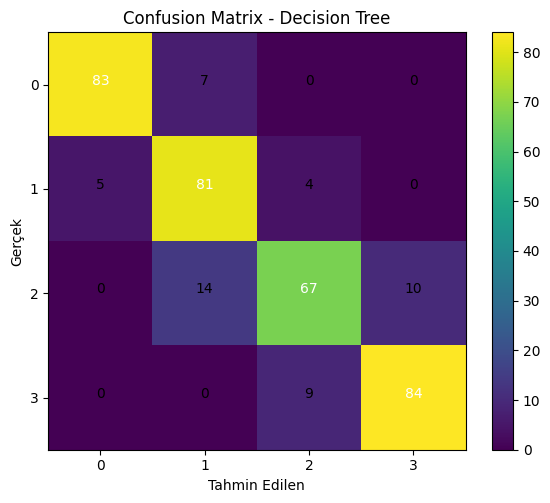

In [67]:
# Confusion Matrix
cm_dt = confusion_matrix(y_test, dt_test_pred)
print("[Decision Tree] Confusion Matrix:")
print(cm_dt)

# Confusion Matrix Görselleştirme (SVM ile aynı stil)
plt.figure(figsize=(6, 5))
plt.imshow(cm_dt, interpolation="nearest")
plt.title("Confusion Matrix - Decision Tree")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")

thresh = cm_dt.max() / 2.
for i in range(cm_dt.shape[0]):
    for j in range(cm_dt.shape[1]):
        plt.text(
            j, i, format(cm_dt[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm_dt[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

### Random Forest Hyperparameter Tuning ile Model Eğitimi

In [76]:
# 3- RANDOM FOREST MODEL
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [200, 300],
    'max_depth': [5, 7, 9, 11],
    'min_samples_split': [10, 20, 30, 40],
    'min_samples_leaf': [5, 8, 10],
    'max_features': ['sqrt', 'log2', 0.3, 0.5]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("\n[Random Forest] En iyi hiperparametreler (GridSearchCV):")
print(grid_rf.best_params_)
print("[Random Forest] En iyi CV skoru (train üzeri 3-fold ortalama):", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_

rf_train_pred = best_rf.predict(X_train)
rf_test_pred  = best_rf.predict(X_test)

rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc  = accuracy_score(y_test, rf_test_pred)

print("\n[Random Forest] Train accuracy:", rf_train_acc)
print("[Random Forest] Test accuracy:", rf_test_acc)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits

[Random Forest] En iyi hiperparametreler (GridSearchCV):
{'max_depth': 11, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
[Random Forest] En iyi CV skoru (train üzeri 3-fold ortalama): 0.8914089347079038

[Random Forest] Train accuracy: 0.9786941580756013
[Random Forest] Test accuracy: 0.9120879120879121


In [77]:
# Classification Report (Test verisi)
print("\n[Random Forest] Classification Report (Test verisi):")
print(classification_report(y_test, rf_test_pred))


[Random Forest] Classification Report (Test verisi):
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        90
           1       0.91      0.91      0.91        90
           2       0.88      0.85      0.86        91
           3       0.89      0.95      0.92        93

    accuracy                           0.91       364
   macro avg       0.91      0.91      0.91       364
weighted avg       0.91      0.91      0.91       364



[Random Forest] Confusion Matrix:
[[85  5  0  0]
 [ 2 82  6  0]
 [ 0  3 77 11]
 [ 0  0  5 88]]


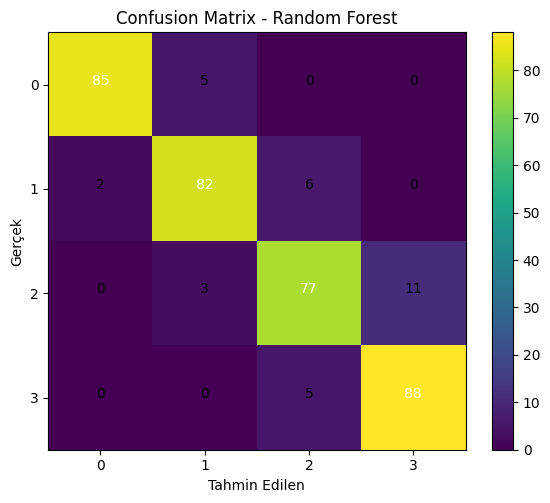

In [78]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_test_pred)
print("[Random Forest] Confusion Matrix:")
print(cm_rf)

# Confusion Matrix Görselleştirme (SVM ve DT ile aynı stil)
plt.figure(figsize=(6, 5))
plt.imshow(cm_rf, interpolation="nearest")
plt.title("Confusion Matrix - Random Forest")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")

thresh = cm_rf.max() / 2.
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        plt.text(
            j, i, format(cm_rf[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm_rf[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

### Logistic Regression Hyperparameter Tuning ile Model Eğitimi

In [ ]:
# Logistic kodu

# Random Forest XAI Shap

c:\Users\furkan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


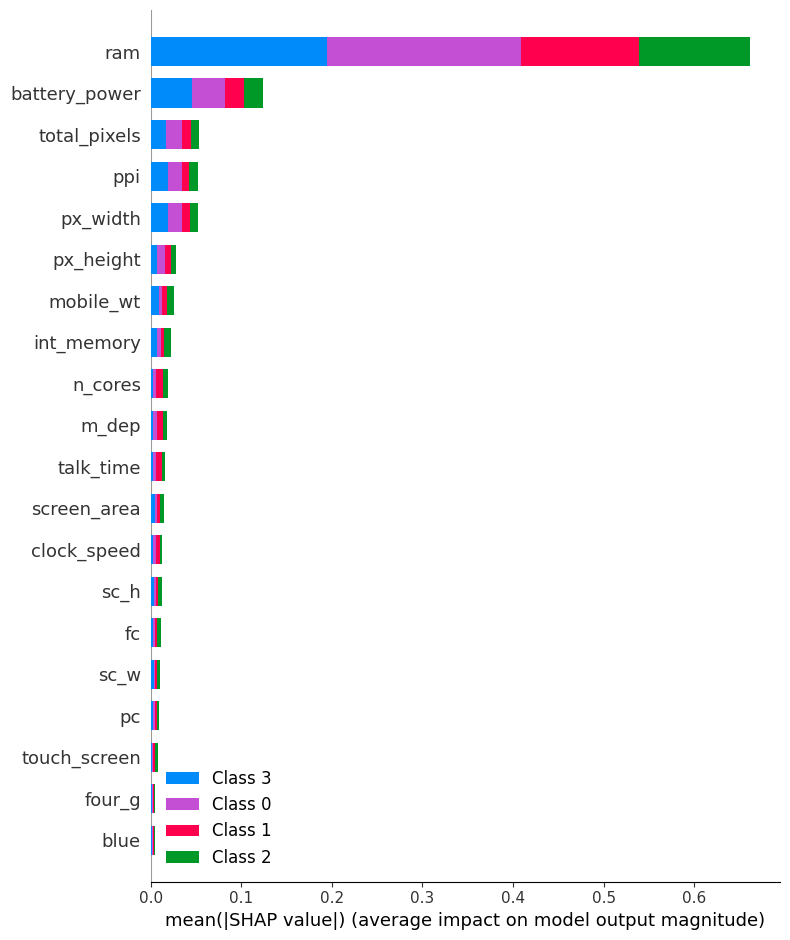

In [49]:
import shap

# Ağaç tabanlı modeller için en hızlı ve uygun explainer
explainer_rf = shap.TreeExplainer(best_rf)

# Test seti için SHAP değerlerini hesaplayalım
# (çok yavaş değil ama istersen X_test'in küçük bir parçasını da kullanabilirsin)
shap_values_rf = explainer_rf.shap_values(X_test)

# Bar tipi özet (feature importance gibi, SHAP tabanlı)
shap.summary_plot(shap_values_rf, X_test, plot_type="bar", show=True)

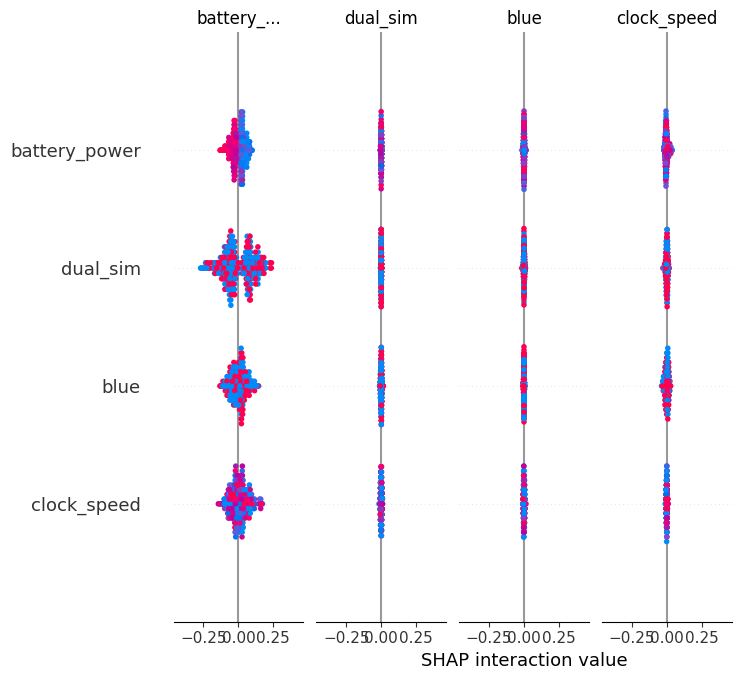

In [50]:
shap.summary_plot(shap_values_rf, X_test, show=True)

In [56]:
# Açıklamak istediğin örnek (i. index)
i = 0
sample = X_test.iloc[[i]]  # DataFrame olarak kalması için çift köşeli

# SHAP değerleri (tek örnek için)
sample_shap_values = explainer_rf.shap_values(sample)

print("sample_shap_values type:", type(sample_shap_values))

# Gerçek ve tahmin edilen sınıf
print("Gerçek sınıf:", y_test.iloc[i])
pred_class = int(best_rf.predict(sample)[0])
print("Tahmin edilen sınıf:", pred_class)

# 1) Eğer shap_values LISTE ise (klasik çok sınıflı çıktı):
if isinstance(sample_shap_values, list):
    values = sample_shap_values[pred_class][0]           # (n_features,)
    base_value = explainer_rf.expected_value[pred_class] # scalar
else:
    # 2) Eğer TEK ARRAY ise → class bazlı ayrım yok, doğrudan ilk satırı al
    values = sample_shap_values[0]                       # (n_features,)
    base_value = explainer_rf.expected_value             # scalar

data_row = sample.iloc[0]

# Waterfall plot
shap.plots.waterfall(
    shap.Explanation(
        values=values,
        base_values=base_value,
        data=data_row,
        feature_names=sample.columns
    )
)

# Force plot (alternatif, istersen)
shap.force_plot(
    base_value,
    values,
    data_row,
    matplotlib=True
)


sample_shap_values type: <class 'numpy.ndarray'>
Gerçek sınıf: 3
Tahmin edilen sınıf: 3


ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (23, 4)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.